In [1]:
!gdown https://drive.google.com/uc?id=1zgT5-UOa9oby2mViweBQTaYmhsfwvHje
!gdown https://drive.google.com/uc?id=1vN-1XjxrA8FJMSLYSta8LjLSPshkKsbl

Downloading...
From: https://drive.google.com/uc?id=1zgT5-UOa9oby2mViweBQTaYmhsfwvHje
To: /content/Generator_v2_150.pth
100% 98.0M/98.0M [00:00<00:00, 292MB/s]
Downloading...
From: https://drive.google.com/uc?id=1vN-1XjxrA8FJMSLYSta8LjLSPshkKsbl
To: /content/Encoder.pth
100% 74.0M/74.0M [00:00<00:00, 223MB/s]


In [2]:
!git clone https://github.com/Palandr1234/NFE.git

Cloning into 'NFE'...
remote: Enumerating objects: 181, done.
remote: Total 181 (delta 0), reused 0 (delta 0), pack-reused 181
Receiving objects: 100% (181/181), 26.74 MiB | 20.71 MiB/s, done.
Resolving deltas: 100% (77/77), done.


In [3]:
from NFE.StyleGAN import *

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from PIL import Image
import glob
import math

import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
G = torch.load("Generator_v2_150.pth", map_location=device)

In [6]:
class ResBlock(nn.Module):
    def __init__(self,in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, 1)
        self.act = nn.LeakyReLU(0.2)
        self.conv1 = nn.Conv2d(in_channels, in_channels, 3, padding=1)
        self.conv2 = nn.Conv2d(in_channels, out_channels, 3, padding=1)

    def forward(self, x):
        return self.act(self.conv(x))+self.act(self.conv2(self.act(self.conv1(x))))

In [7]:
class Encoder(nn.Module):
    def __init__(self, z_dim=512):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1), 
            nn.LeakyReLU(0.2),
            nn.AvgPool2d(2),
            ResBlock(64, 128),
            nn.AvgPool2d(2),
            ResBlock(128, 256),
            nn.AvgPool2d(2),
            ResBlock(256, 512),
            nn.AvgPool2d(2),
            ResBlock(512, 1024),
        )   
        self.linear = nn.Linear(1024*4*4, 512)         
  
    def forward(self, x):
        x = self.conv(x)
        x = x.reshape(x.size(0), -1)
        return self.linear(x)

In [8]:
E = torch.load("Encoder.pth", map_location=device)

In [9]:
transform=transforms.Compose([
                               transforms.Resize((64, 64)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
img = Image.open("kurapika.jpg").convert("RGB")
img = transform(img).unsqueeze(0)

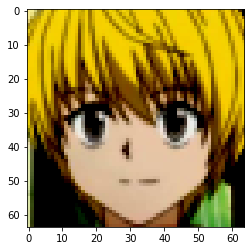

In [10]:
plt.imshow(img[0].permute([1,2,0]).numpy())

In [11]:
z_dim=512
step = int(math.log(z_dim, 2)) -2
img=img.to(device)

In [12]:
with torch.no_grad():
  z = E(img.to(device))
z=torch.clip(z, 0, 1)
z.requires_grad_(True)
z.retain_grad()
lr = 1e-2
optimizer = torch.optim.Adam([z], lr= lr)

criterion = torch.nn.MSELoss(reduction="sum")

In [13]:
losses = []
epochs=1000
f = torchvision.transforms.functional.gaussian_blur
for i in range(epochs):
    optimizer.zero_grad()
    
    out = G(z, step=step)
  
    loss = criterion(f(out, 3, 11.0), f(img, 3, 11.0))+20.0*torch.norm(z, p=2.0)
    losses.append(loss.item())
    loss.backward()
    optimizer.step()

    if i % 20 == 0:
        print("iter {:04d}: y_error = {:03g}".format(i,
            loss.item()))

iter 0000: y_error = 3188.97
iter 0020: y_error = 1575.91
iter 0040: y_error = 1350.11
iter 0060: y_error = 1263.92
iter 0080: y_error = 1208.99
iter 0100: y_error = 1171.89
iter 0120: y_error = 1142.39
iter 0140: y_error = 1115.32
iter 0160: y_error = 1084.63
iter 0180: y_error = 1065.19
iter 0200: y_error = 1049.76
iter 0220: y_error = 1029.33
iter 0240: y_error = 1006.62
iter 0260: y_error = 979.578
iter 0280: y_error = 954.433
iter 0300: y_error = 928.719
iter 0320: y_error = 901.131
iter 0340: y_error = 878.832
iter 0360: y_error = 860.659
iter 0380: y_error = 831.389
iter 0400: y_error = 804.429
iter 0420: y_error = 783.395
iter 0440: y_error = 761.151
iter 0460: y_error = 736.491
iter 0480: y_error = 717.584
iter 0500: y_error = 708.507
iter 0520: y_error = 693.525
iter 0540: y_error = 673.156
iter 0560: y_error = 660.569
iter 0580: y_error = 639.47
iter 0600: y_error = 628.623
iter 0620: y_error = 623.09
iter 0640: y_error = 605.442
iter 0660: y_error = 592.157
iter 0680: y_err

In [14]:
res = G(z, step=step)

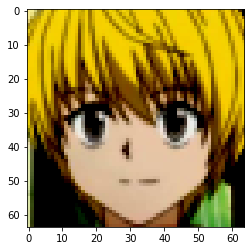

In [15]:
plt.imshow(img[0].permute([1,2,0]).detach().cpu().numpy())

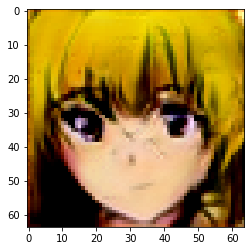

In [16]:
plt.imshow(res[0].permute([1,2,0]).detach().cpu())